# Проект

**Описание проекта:** HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.

Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 

**Первая задача**: построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 

Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.

**Вторая задача**: построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

**Импорт библиотек**

In [1]:
pip install --upgrade scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install phik

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler, 
    OneHotEncoder, 
    LabelEncoder,
    OrdinalEncoder)
from sklearn.impute import SimpleImputer


from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import roc_auc_score, make_scorer

from sklearn.feature_selection import SelectKBest, f_classif

RANDOM_STATE = 42
pd.set_option('display.max_colwidth', None)

## Задача №1

### Загрузка данных

In [4]:
train = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
X_test = pd.read_csv('/datasets/test_features.csv')
y_test = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')

In [5]:
display(train.head())
print(train.shape)
print()
train.info()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


(4000, 10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [6]:
display(X_test.head())
print(X_test.shape)
print()
X_test.info()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


(2000, 9)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [7]:
display(y_test.head())
print(y_test.shape)
print()
y_test.info()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


(2000, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


*Вывод:*

1. данные загружены и соотвествуют ТЗ
2. для train: количество строк - 4000, количество столбцов - 10
3. для X_test: количество строк - 2000, количество столбцов - 9
4. для y_test: количество строк - 2000, количество столбцов - 2
5. называния столбцов не нуждаются в переименовывании
6. в типах данных ошибок нет

### Предобработка данных

**Функция для предобработки данных**

1. Приводит все значения к нижнему регистру
2. Выводит информацию и пропусках и дубликатах

In [8]:
def prepare(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].str.lower()
    nulls = df.isna().sum()
    print(f'количество пропусков в датафрейме:')
    print(nulls)
    
    dupls = df.duplicated().sum()
    print(f'количество явных дубликатов = {dupls}')
    if dupls > 0:
        df.drop_duplicates(inplace = True)
        print(f'количество явных дубликатов после удаления = {df.duplicated().sum()}')
    
    for col in df.select_dtypes('object').columns:
        print(f'Уникальные значения в {col} :')
        print(df[col].unique())
    
    return df

*№1 train*

In [9]:
prepare(train).head()

количество пропусков в датафрейме:
id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64
количество явных дубликатов = 0
Уникальные значения в dept :
['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
Уникальные значения в level :
['junior' 'middle' 'sinior' nan]
Уникальные значения в workload :
['medium' 'high' 'low']
Уникальные значения в last_year_promo :
['no' 'yes']
Уникальные значения в last_year_violations :
['no' 'yes']


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


Пропуски составляют 0,0025 от всех данных, их можно удалить

In [10]:
train.isna().sum()

id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

*№2 X_test*

In [11]:
prepare(X_test).head()

количество пропусков в датафрейме:
id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64
количество явных дубликатов = 0
Уникальные значения в dept :
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
Уникальные значения в level :
['junior' 'middle' 'sinior' nan]
Уникальные значения в workload :
['medium' 'low' 'high' ' ']
Уникальные значения в last_year_promo :
['no' 'yes']
Уникальные значения в last_year_violations :
['no' 'yes']


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


Так же есть значения ' ', от которых нужно избавиться

Пропуски будут обработаны в пункте 1.5

In [12]:
X_test.isna().sum()

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

*№3 y_test*

In [13]:
prepare(y_test).head()

количество пропусков в датафрейме:
id                       0
job_satisfaction_rate    0
dtype: int64
количество явных дубликатов = 0


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


Для тренировочной выборки проверим еще дубликаты, без учета индекса

In [14]:
train = train.set_index('id')
X_test = X_test.set_index('id')
y_test = y_test.set_index('id')

In [15]:
train.duplicated().sum()

245

In [16]:
train.drop_duplicates(inplace = True)

In [17]:
train.duplicated().sum()

0

*Выводы:*

для train:

1. были обнаружены пропущенные значения 
2. неявных дубликатов нет
3. были удалены явные дубликаты

для X_test:

1. были обнаружены пропущенные значения
2. неявных дубликатов нет
3. явных дубликатов нет

для y_test:

1. пропусков нет
2. явных дубликатов нет

### Исследовательский анализ

*1. train*

In [18]:
numeric_columns = train.select_dtypes(include=['int64', 'float64']).columns

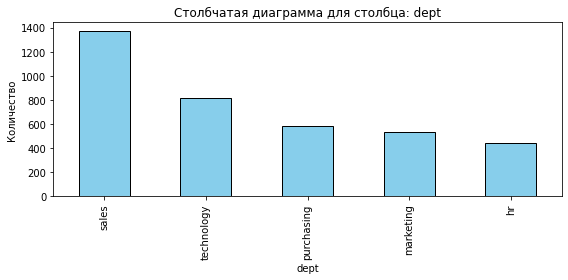

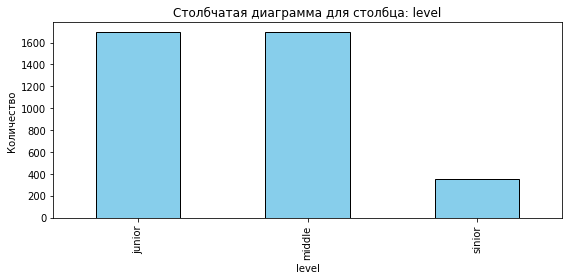

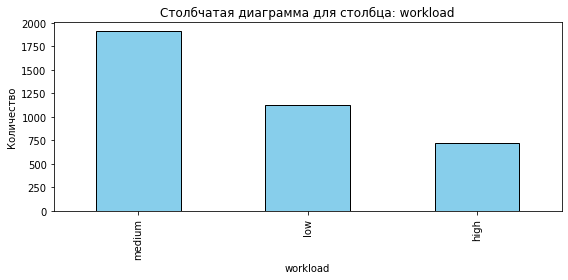

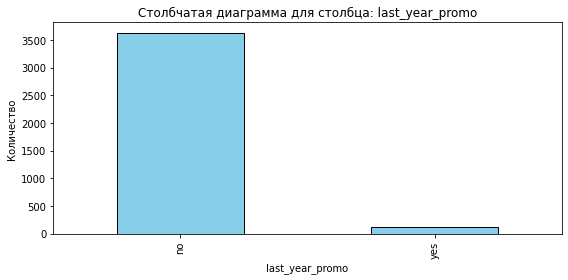

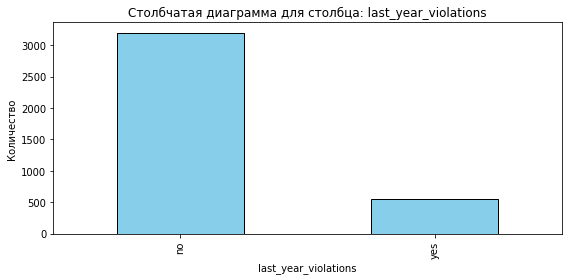

In [19]:
for column in train.select_dtypes(include=['object']).columns:
    plt.figure(figsize=(8, 4))
    train[column].value_counts().plot(kind='bar', color = 'skyblue', edgecolor = 'black')
    plt.title(f'Столбчатая диаграмма для столбца: {column}')
    plt.xlabel(column)
    plt.ylabel('Количество')
    plt.tight_layout()
    plt.show()

*Промежуточный вывод:*

1. По сравнению с junior и middle, людей с должностью sinior мало 
2. Чаще всего работники имеют среднюю загруженность
3. Почти всех сотрудников не повышали за год
4. Большинство сотрудников не нарушало трудовой договор

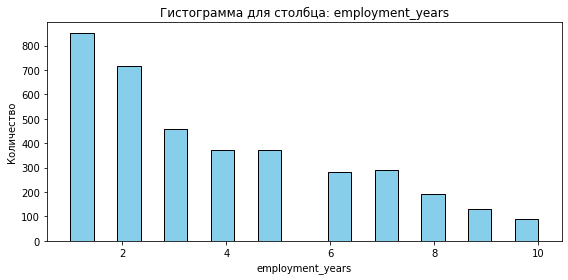

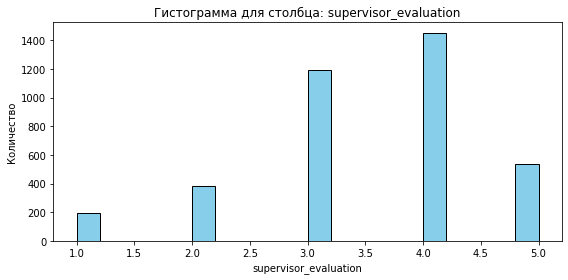

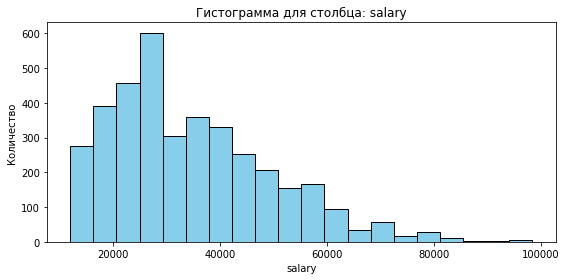

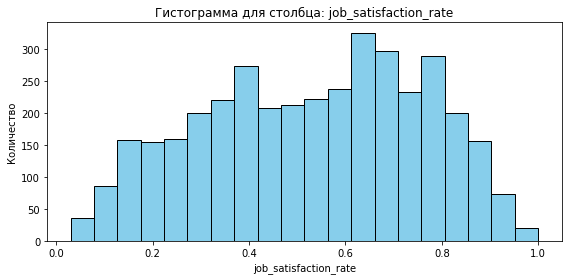

In [20]:
for column in numeric_columns:
    plt.figure(figsize=(8, 4))
    train[column].plot(kind='hist', bins=20, color = 'skyblue',edgecolor='black')
    plt.title(f'Гистограмма для столбца: {column}')
    plt.xlabel(column)
    plt.ylabel('Количество')
    plt.tight_layout()
    plt.show()

In [21]:
train['job_satisfaction_rate'].median()

0.55

*Промежуточный вывод:*

1. Новых сотрудников больше, чем старых
2. Самая частая оценка работы сотрудника - 4
3. Имеются экстремальные значения для зарплаты, надо посмотреть подробнее
4. Больше сотруднков имеют уровень удовлетворенности работой > 0.5

Построим дополнительный график для salary

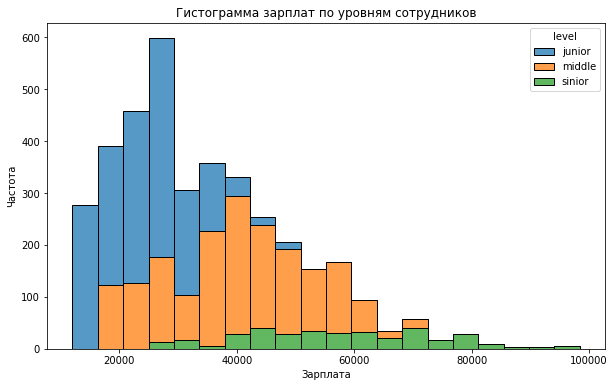

In [22]:
plt.figure(figsize=(10, 6))
sns.histplot(data=train, x='salary', hue='level', multiple='stack', bins=20)

plt.title('Гистограмма зарплат по уровням сотрудников')
plt.xlabel('Зарплата')
plt.ylabel('Частота')
plt.show()

Ожидание подтвердились, сотрудники с уровнем "sinior" имеют зарплату выше, чем у других уровней. Исходя из этого, мы не будем исключать эти данные, так как они вполне реальны

2. X_test

In [23]:
numeric_columns = X_test.select_dtypes(include=['int64', 'float64']).columns

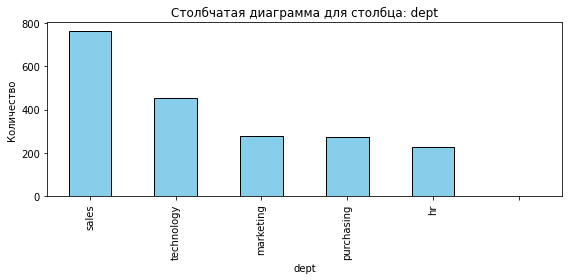

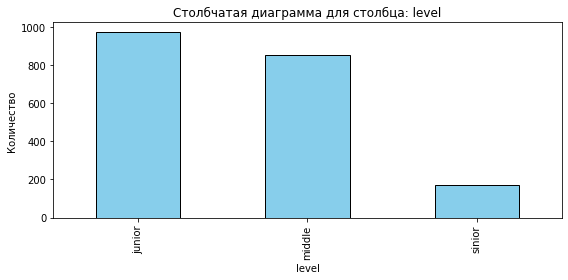

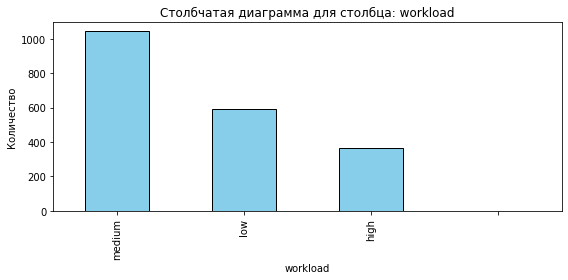

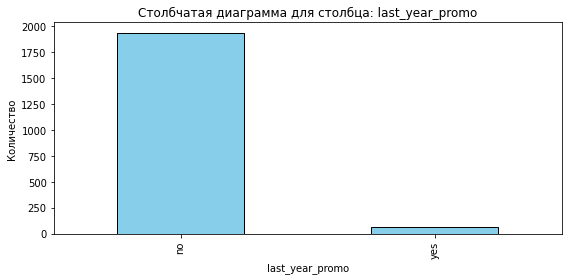

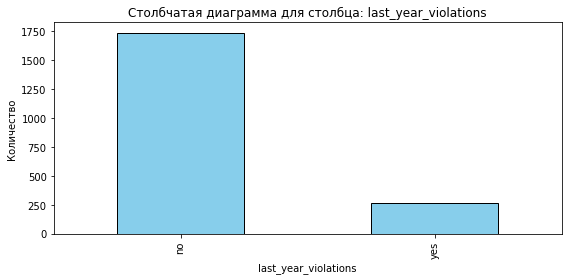

In [24]:
for column in X_test.select_dtypes(include=['object']).columns:
    plt.figure(figsize=(8, 4))
    X_test[column].value_counts().plot(kind='bar', color = 'skyblue', edgecolor = 'black')
    plt.title(f'Столбчатая диаграмма для столбца: {column}')
    plt.xlabel(column)
    plt.ylabel('Количество')
    plt.tight_layout()
    plt.show()

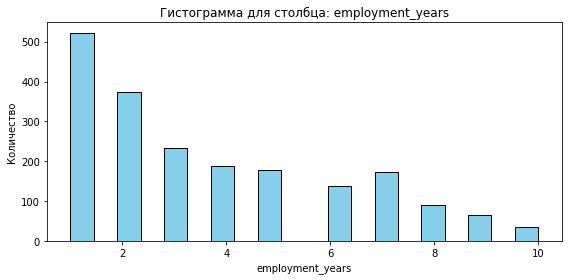

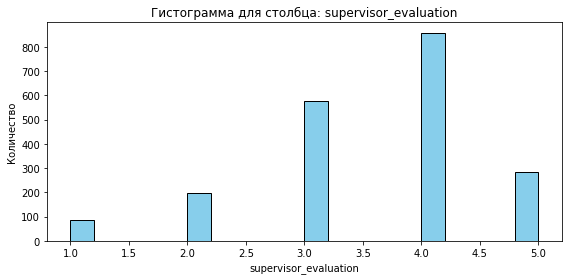

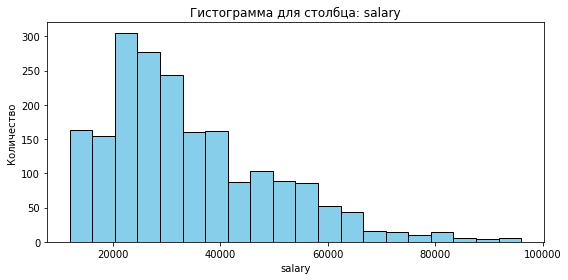

In [25]:
for column in numeric_columns:
    plt.figure(figsize=(8, 4))
    X_test[column].plot(kind='hist', bins=20, color = 'skyblue',edgecolor='black')
    plt.title(f'Гистограмма для столбца: {column}')
    plt.xlabel(column)
    plt.ylabel('Количество')
    plt.tight_layout()
    plt.show()

Структура данных тестовой выборки похожа на структуру данных тренировочной выборки

*Вывод:*

1. По сравнению с junior и middle, людей с должностью sinior мало 
2. Чаще всего работники имеют среднюю загруженность
3. Почти всех сотрудников не повышали за год
4. Большинство сотрудников не нарушало трудовой договор
5. Новых сотрудников больше, чем старых
6. Самая частая оценка работы сотрудника - 4
7. Имеются экстремальные значения для зарплаты, надо посмотреть подробнее
8. Больше сотруднков имеют уровень удовлетворенности работой > 0.5
9. Структуры данных тренировочной и тестовой выборок совпадают

### Корреляционный анализ

Проверим мультиколлинеарность


interval columns not set, guessing: ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']


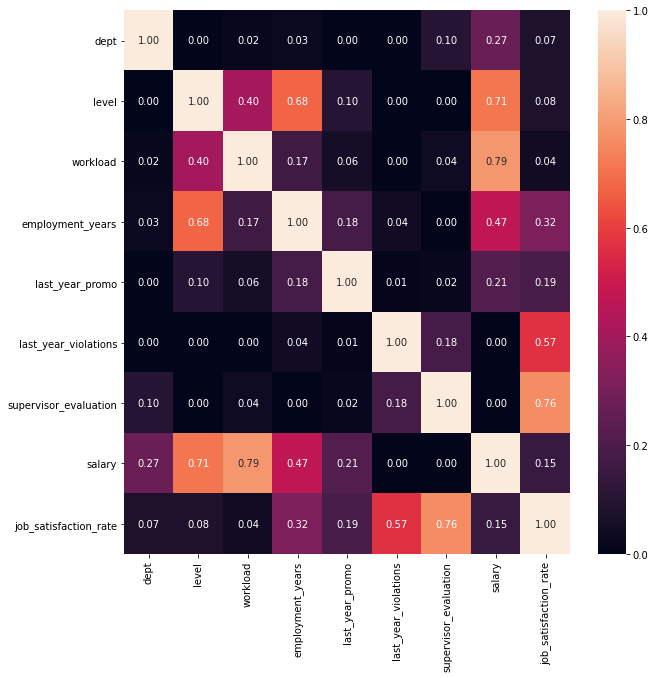

In [26]:
plt.figure(figsize=(10, 10))
phik_corr = train.phik_matrix()
sns.heatmap(phik_corr, annot=True, fmt='.2f')
plt.show()

Мультиколлинеарности нет: везде коэф. корреляции не выше 0.8

### Подготовка данных

Разработка паплайна

In [27]:
X_train = train.drop(['job_satisfaction_rate'], axis=1)
X_train = X_train.sort_index()

In [28]:
y_train = train['job_satisfaction_rate']
y_train = y_train.sort_index()

In [29]:
X_test = X_test.sort_index()
y_test = y_test.sort_index()

In [30]:
X_test.shape, y_test.shape

((2000, 8), (2000, 1))

In [31]:
df = X_test.merge(y_test, left_index=True, right_index=True)

X_test = df.drop(['job_satisfaction_rate'], axis=1)
y_test = df['job_satisfaction_rate']

In [32]:
ohe_col = ['dept', 'last_year_promo', 'last_year_violations']
ord_col = ['level', 'workload']
num_col = ['employment_years', 'supervisor_evaluation', 'salary']

In [33]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore')
        )
    ]
)

ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'],
                    ['low', 'medium', 'high'],
                ], 
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_col),
        ('ord', ord_pipe, ord_col),
        ('num', StandardScaler(), num_col)
    ], 
    remainder='passthrough'
)

pipe_final= Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]
)

*Вывод:*

Создан паплайн с кодировщиками: OrdinalEncoder и OneHotEncoder, и маштабированием с помощью StandardScaler

### Обучение моделей

In [34]:
param_distributions = [
    {
        'models': [KNeighborsRegressor()],
        'models__n_neighbors': range(1, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]   
    },
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 11),
        'models__min_samples_split': range(2, 11),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [SVR()],
        'models__C': [0.1, 1, 10, 100],  
        'models__gamma': ['scale', 'auto'], 
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

Метрика SMAPE

In [35]:
def smape(true, pred):
    denominator = (np.abs(true) + np.abs(pred)) / 2
    diff = np.abs(true - pred) / denominator
    return np.mean(diff) * 100


smape_score = make_scorer(smape, greater_is_better=False)

In [36]:
grid_reg = GridSearchCV(pipe_final, 
                    param_distributions, 
                    cv=5, 
                    n_jobs=-1,
                    scoring=smape_score
)

In [37]:
grid_reg.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['dept',
                                                                          'last_year_promo',
                                                                          'last_year_violations']),
                                                                        ('ord',
                                                                         Pipeline(steps=[('simpleImput...
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [SVR()], 'models__C': [0.1, 1, 10, 100],
                          'models__gamma': ['scale', 'auto'],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [LinearRegression()],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring=make_scorer(smape, greater_is_better=False, response_method='predict'))

In [38]:
results_1 = grid_reg.cv_results_
results_df_1 = pd.DataFrame(results_1)

ranking_columns_1 = ['params', 'mean_test_score', 'rank_test_score']
ranking_df_1 = results_df_1[ranking_columns_1].sort_values(by='rank_test_score')

print("Рейтинг моделей:")
display(ranking_df_1.head(10))

Рейтинг моделей:


,params,mean_test_score,rank_test_score
293,"{'models': SVR(), 'models__C': 10, 'models__gamma': 'scale', 'preprocessor__num': StandardScaler()}",-14.744531,1
287,"{'models': SVR(), 'models__C': 1, 'models__gamma': 'scale', 'preprocessor__num': StandardScaler()}",-14.782383,2
296,"{'models': SVR(), 'models__C': 10, 'models__gamma': 'auto', 'preprocessor__num': StandardScaler()}",-15.054401,3
302,"{'models': SVR(), 'models__C': 100, 'models__gamma': 'auto', 'preprocessor__num': StandardScaler()}",-15.292081,4
299,"{'models': SVR(), 'models__C': 100, 'models__gamma': 'scale', 'preprocessor__num': StandardScaler()}",-15.973906,5
274,"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 10, 'models__min_samples_split': 8, 'preprocessor__num': 'passthrough'}",-16.068207,6
273,"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 10, 'models__min_samples_split': 8, 'preprocessor__num': MinMaxScaler()}",-16.071564,7
272,"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 10, 'models__min_samples_split': 8, 'preprocessor__num': StandardScaler()}",-16.096645,8
271,"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 10, 'models__min_samples_split': 7, 'preprocessor__num': 'passthrough'}",-16.113160,9
270,"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 10, 'models__min_samples_split': 7, 'preprocessor__num': MinMaxScaler()}",-16.116518,10


Лидирует модель SVR, место в рейтинге зависит от гиперпараметров модели

Другая модель, которая хорошо себя показала - DecisionTreeRegressor

In [39]:
best_regressor = grid_reg.best_estimator_

In [40]:
y_pred = best_regressor.predict(X_test)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [41]:
smape(y_test, y_pred)

13.552876716246685

Так как критерий успеха - SMAPE <= 15, то можем назвать эту модель успешной

*Выводы:*

1. было обучено 4 модели: KNeighborsRegressor, DecisionTreeRegressor, SVR, LinearRegression
2. была создана метрика SMAPE
3. была найдена лучшая модель: SVR(C=10) c SMAPE = 13.551

### Выводы к задаче №1

*Вывод:*

1. Данные были загружены и проверенв на соотвествие ТЗ
2. Была создана функция для предобработки данных: значения приведены к нижнему регистру, удалены явные дубликаты, проверены потенциальные неявные дубликаты, исправлены некорректные значения
3. Были построены графики для каждого из признаков, проведено сравнение структуры данных в тестовой и тренировочной выборках
4. Была проведена проверка на мультиколлинеарность: не обнаружена
5. Был создан паплайн с кодированием (OneHotEncoder, OrdinalEncoder) и маштабированием (StandardScaler), также заполнены пропуски в паплайне с помощью SimpleImputer
6. Был проведен поиск гиперпараметров с помощью GridSearchCV для моделей: KNeighborsRegressor, DecisionTreeRegressor, SVR, LinearRegression
7. Создана метрика SMAPE
8. Лучшая модель: SVR(C=10) cо значением метрики SMAPE = 13.551

## Задача №2

### Загрузка данных

In [42]:
train_2 = pd.read_csv('/datasets/train_quit.csv')
X_test_2 = pd.read_csv('/datasets/test_features.csv')
y_test_2 = pd.read_csv('/datasets/test_target_quit.csv')

In [43]:
print(train_2.info())
print()
display(train_2.head())
print(train_2.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB
None



,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


(4000, 10)


In [44]:
print(X_test_2.info())
print()
display(X_test_2.head())
print(X_test_2.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB
None



,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


(2000, 9)


In [45]:
print(y_test_2.info())
print()
display(y_test_2.head())
print(y_test_2.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB
None



,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


(2000, 2)


*Вывод:*

1. данные загружены и соотвествуют ТЗ
2. для train_2: количество строк - 4000, количество столбцов - 10
3. для X_test_2: количество строк - 2000, количество столбцов - 9
4. для y_test_2: количество строк - 2000, количество столбцов - 2
5. называния столбцов не нуждаются в переименовывании
6. в типах данных ошибок нет

### Предобработка данных

1. train_2

In [46]:
prepare(train_2).head()

количество пропусков в датафрейме:
id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64
количество явных дубликатов = 0
Уникальные значения в dept :
['sales' 'purchasing' 'marketing' 'technology' 'hr']
Уникальные значения в level :
['middle' 'junior' 'sinior']
Уникальные значения в workload :
['high' 'medium' 'low']
Уникальные значения в last_year_promo :
['no' 'yes']
Уникальные значения в last_year_violations :
['no' 'yes']
Уникальные значения в quit :
['no' 'yes']


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


2. X_test_2

In [47]:
prepare(X_test_2).head()

количество пропусков в датафрейме:
id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64
количество явных дубликатов = 0
Уникальные значения в dept :
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
Уникальные значения в level :
['junior' 'middle' 'sinior' nan]
Уникальные значения в workload :
['medium' 'low' 'high' ' ']
Уникальные значения в last_year_promo :
['no' 'yes']
Уникальные значения в last_year_violations :
['no' 'yes']


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


Пропуски мы обработаем в пункте 2.6

3. y_test_2

In [48]:
prepare(y_test_2).head()

количество пропусков в датафрейме:
id      0
quit    0
dtype: int64
количество явных дубликатов = 0
Уникальные значения в quit :
['yes' 'no']


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


In [49]:
train_2 = train_2.set_index('id')
X_test_2 = X_test_2.set_index('id')
y_test_2 = y_test_2.set_index('id')

In [50]:
train_2.duplicated().sum()

1413

*Выводы:*

для train:

1. не были найдены пропущенные значения 
2. неявных дубликатов нет
3. были удалены явные дубликаты

для X_test:

1. были найдены пропущенные значения
2. неявных дубликатов нет
3. явных дубликатов нет

для y_test:

1. пропусков нет
2. явных дубликатов нет

### Исследовательский анализ данных

1. train_2

In [51]:
numeric_columns = train_2.select_dtypes(include=['int64', 'float64']).columns

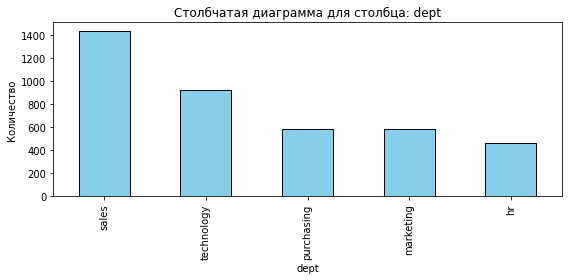

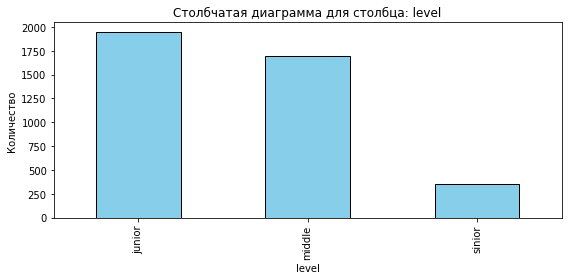

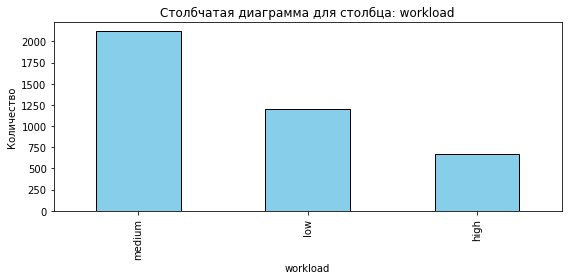

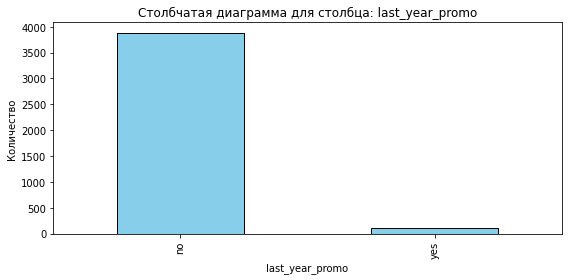

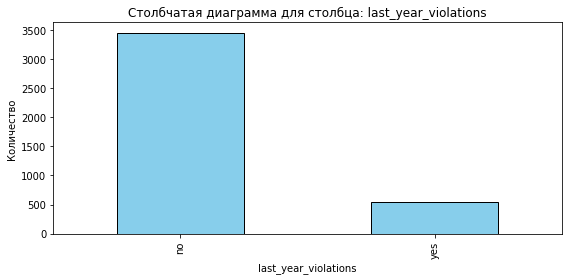

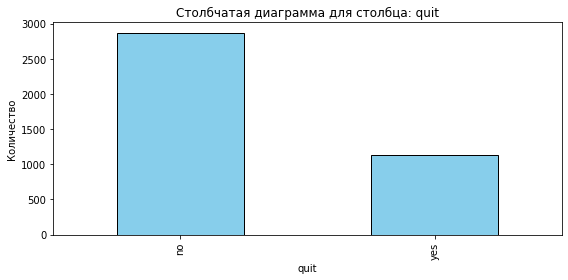

In [52]:
for column in train_2.select_dtypes(include=['object']).columns:
    plt.figure(figsize=(8, 4))
    train_2[column].value_counts().plot(kind='bar', color = 'skyblue', edgecolor = 'black')
    plt.title(f'Столбчатая диаграмма для столбца: {column}')
    plt.xlabel(column)
    plt.ylabel('Количество')
    plt.tight_layout()
    plt.show()

*Промежуточный вывод:*

1. больше всего сотрудников уровня "middle", меньше всего - "sinior"
2. больше всего умереннно загруженных сотрудников
3. у большинства сотрудников не было повышений за год
4. у большинства сотрудников не было нарушений
5. целевой признак - дисбаланс выборок

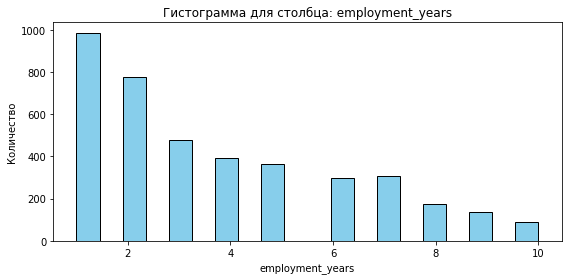

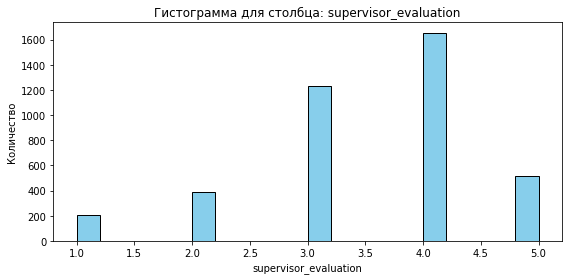

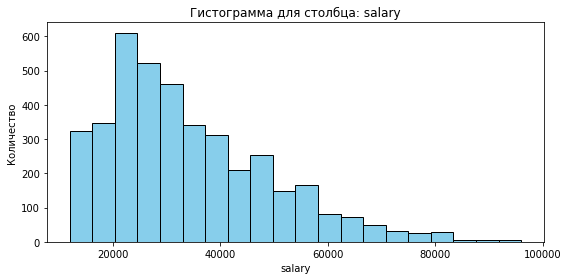

In [53]:
for column in numeric_columns:
    plt.figure(figsize=(8, 4))
    train_2[column].plot(kind='hist', bins=20, color = 'skyblue',edgecolor='black')
    plt.title(f'Гистограмма для столбца: {column}')
    plt.xlabel(column)
    plt.ylabel('Количество')
    plt.tight_layout()
    plt.show()

*Промежуточный вывод:*

1. больше новых сотрудников, чем старых
2. чаще всего оценки сотрудников 3-4
3. как правило, чем выше уровень сотрудника, тем больше у него зарплата, что и логично

2. X_test_2

In [54]:
numeric_columns = X_test_2.select_dtypes(include=['int64', 'float64']).columns

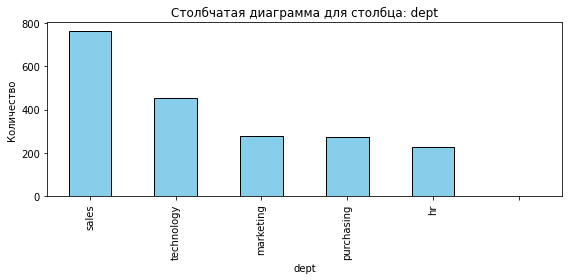

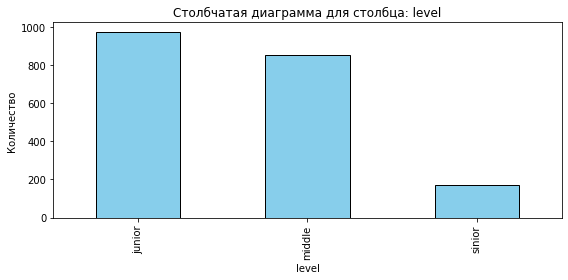

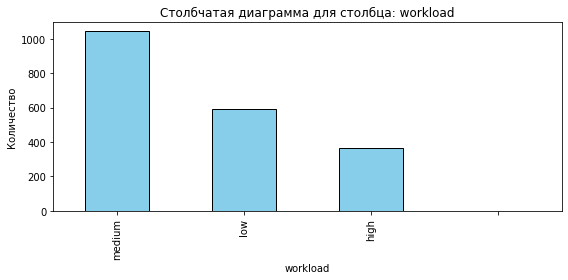

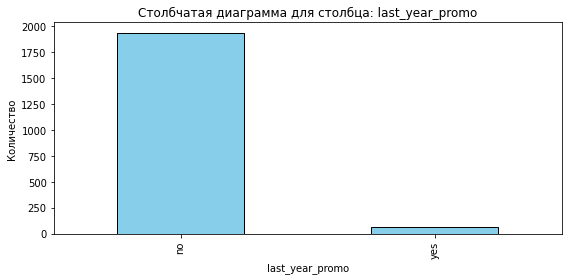

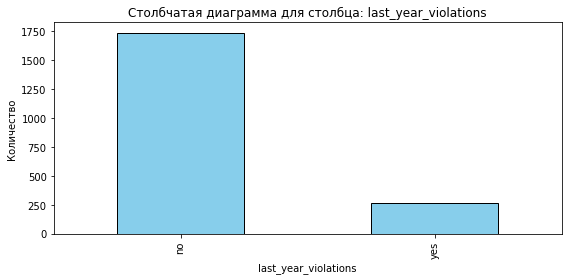

In [55]:
for column in X_test_2.select_dtypes(include=['object']).columns:
    plt.figure(figsize=(8, 4))
    X_test_2[column].value_counts().plot(kind='bar', color = 'skyblue', edgecolor = 'black')
    plt.title(f'Столбчатая диаграмма для столбца: {column}')
    plt.xlabel(column)
    plt.ylabel('Количество')
    plt.tight_layout()
    plt.show()

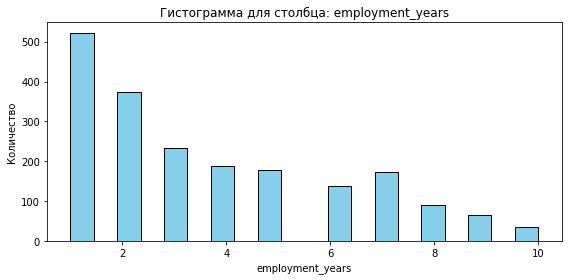

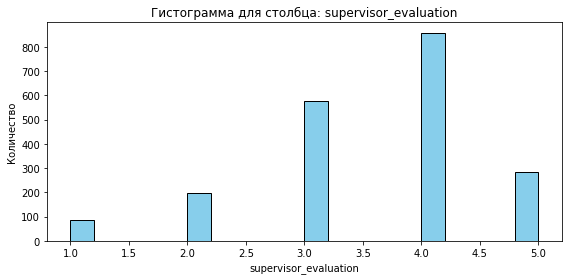

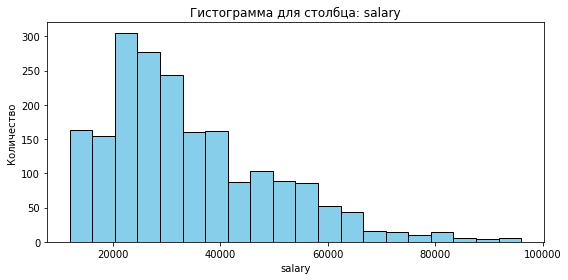

In [56]:
for column in numeric_columns:
    plt.figure(figsize=(8, 4))
    X_test_2[column].plot(kind='hist', bins=20, color = 'skyblue',edgecolor='black')
    plt.title(f'Гистограмма для столбца: {column}')
    plt.xlabel(column)
    plt.ylabel('Количество')
    plt.tight_layout()
    plt.show()

Структура данных тестовой и тренировочной выборок похожа

**Портрет «уволившегося сотрудника»**

In [57]:
quit_data = train_2.query('quit == "yes"')

In [58]:
quit_by_dept = train_2.groupby('dept')['quit'].value_counts(normalize=True).unstack().fillna(0)
quit_by_dept['quit_ratio'] = quit_by_dept['yes'] / (quit_by_dept['yes'] + quit_by_dept['no'])
quit_by_dept = quit_by_dept[['quit_ratio']].sort_values(by='quit_ratio', ascending=False)

print("Доля уволившихся сотрудников по отделам:")
print(quit_by_dept)

Доля уволившихся сотрудников по отделам:
quit        quit_ratio
dept                  
technology    0.297414
sales         0.283032
purchasing    0.282313
marketing     0.280069
hr            0.250000


In [59]:
quit_by_level = train_2.groupby('level')['quit'].value_counts(normalize=True).unstack().fillna(0)
quit_by_level['quit_ratio'] = quit_by_level['yes'] / (quit_by_level['yes'] + quit_by_level['no'])
quit_by_level = quit_by_level[['quit_ratio']].sort_values(by='quit_ratio', ascending=False)

print("Доля уволившихся сотрудников по уровню:")
print(quit_by_level)

Доля уволившихся сотрудников по уровню:
quit    quit_ratio
level             
junior    0.514623
middle    0.063754
sinior    0.047619


In [60]:
quit_by_workload = train_2.groupby('workload')['quit'].value_counts(normalize=True).unstack().fillna(0)
quit_by_workload['quit_ratio'] = quit_by_workload['yes'] / (quit_by_workload['yes'] + quit_by_workload['no'])
quit_by_workload = quit_by_workload[['quit_ratio']].sort_values(by='quit_ratio', ascending=False)

print("Доля уволившихся сотрудников по степени загруженности:")
print(quit_by_workload)

Доля уволившихся сотрудников по степени загруженности:
quit      quit_ratio
workload            
low         0.429636
medium      0.230406
high        0.179525


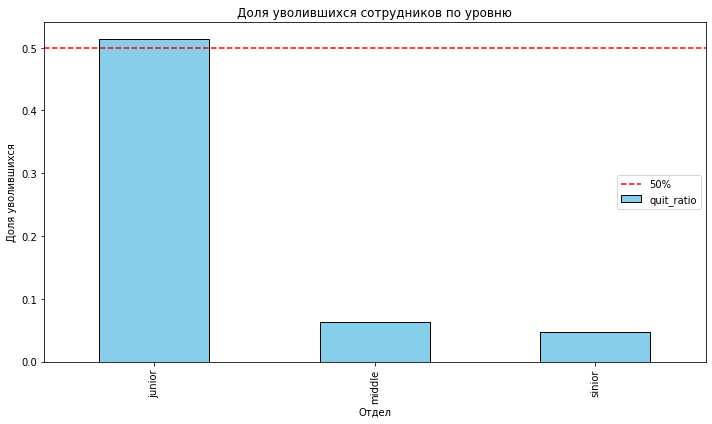

In [61]:
plt.figure(figsize=(10, 6))
quit_by_level['quit_ratio'].plot(kind='bar', color='skyblue', edgecolor = 'black')
plt.title('Доля уволившихся сотрудников по уровню')
plt.xlabel('Отдел')
plt.ylabel('Доля уволившихся')
plt.axhline(0.5, color='red', linestyle='--', label='50%')
plt.legend()
plt.tight_layout()
plt.show()

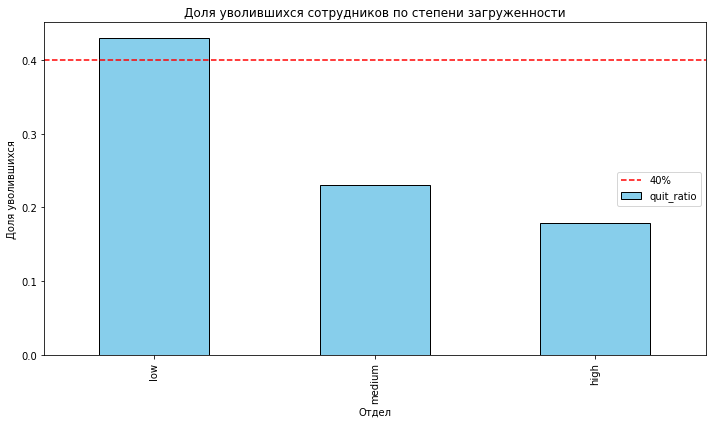

In [62]:
plt.figure(figsize=(10, 6))
quit_by_workload['quit_ratio'].plot(kind='bar', color='skyblue', edgecolor = 'black')
plt.title('Доля уволившихся сотрудников по степени загруженности')
plt.xlabel('Отдел')
plt.ylabel('Доля уволившихся')
plt.axhline(0.4, color='red', linestyle='--', label='40%')
plt.legend()
plt.tight_layout()
plt.show()

Больше всего уволившихся сотрудников в "technology"

Больше всего уволившихся сотрудников с низким уровнем загруженности

Больше всего уволившихся сотрудников с уровнем junior

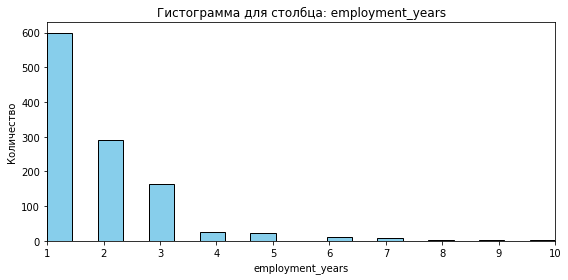

In [63]:
plt.figure(figsize=(8, 4))
quit_data['employment_years'].plot(kind='hist', bins=20, color = 'skyblue',edgecolor='black')
plt.title(f'Гистограмма для столбца: employment_years')
plt.xlabel('employment_years')
plt.ylabel('Количество')
plt.xlim(1, 10)
plt.tight_layout()
plt.show()

Больше всего увольняются в первый год работы, после 3-го уже мало увольнений

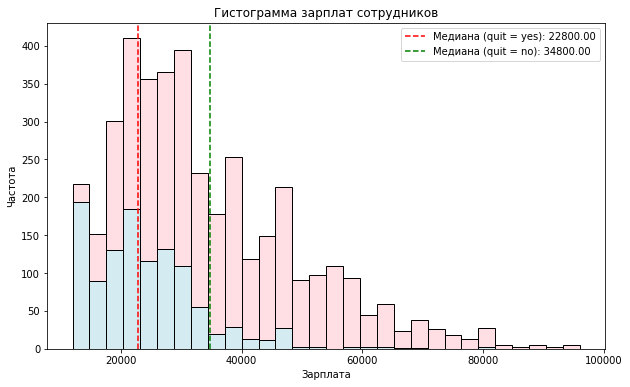

In [64]:
median_quit_yes = train_2[train_2['quit'] == 'yes']['salary'].median()
median_quit_no = train_2[train_2['quit'] == 'no']['salary'].median()

plt.figure(figsize=(10, 6))
sns.histplot(data=train_2, x='salary', hue='quit', bins=30, alpha=0.5, multiple='stack', palette=['pink', 'lightblue'])

plt.axvline(median_quit_yes, color='red', linestyle='--', label=f'Медиана (quit = yes): {median_quit_yes:.2f}')
plt.axvline(median_quit_no, color='green', linestyle='--', label=f'Медиана (quit = no): {median_quit_no:.2f}')

plt.title('Гистограмма зарплат сотрудников')
plt.xlabel('Зарплата')
plt.ylabel('Частота')
plt.legend()

plt.show()

Можно сказать, что у уволившихся сотрудников была зарплата меньше, чем у тех, кто остался в компании

*Вывод*

1. Больше всего уволившихся сотрудников в "technology"
2. Больше всего уволившихся сотрудников с низким уровнем загруженности
3. Больше всего уволившихся сотрудников с уровнем junior
4. Больше всего увольняются в первый год работы, после 3-го уже мало увольнений
5. У уволившихся сотрудников была зарплата меньше, чем у тех, кто остался в компании

In [65]:
df = X_test_2.merge(y_test_2, left_index=True, right_index=True).merge(
    y_test, left_index=True, right_index=True
)

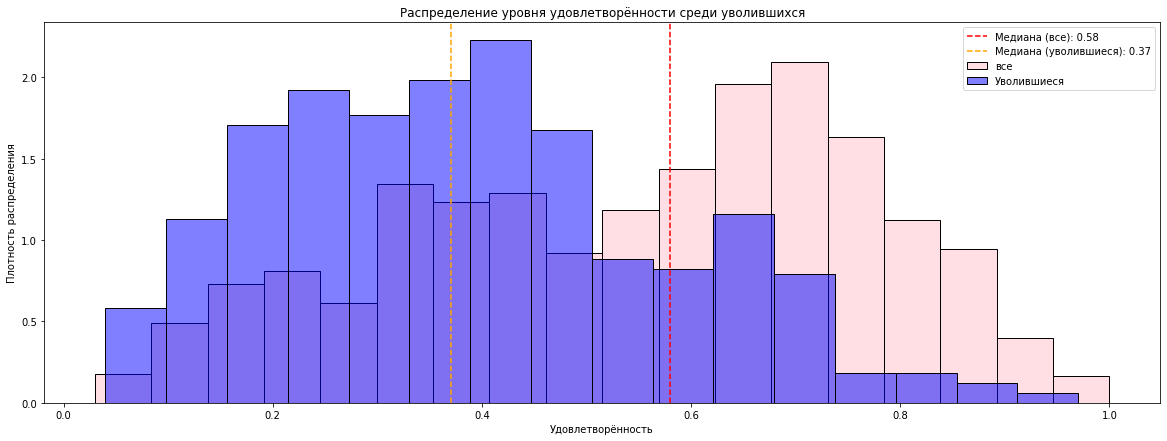

In [66]:
fig, ax = plt.subplots(figsize=(20, 7))
plt.title('Распределение уровня удовлетворённости среди уволившихся')

sns.histplot(
    df['job_satisfaction_rate'],
    stat='density',
    common_norm=False,
    alpha=0.5,
    label='все',
    color='pink',
    ax=ax,
)

sns.histplot(
    df.query('quit == "yes"')['job_satisfaction_rate'],
    stat='density',
    common_norm=False,
    alpha=0.5,
    label='Уволившиеся',
    color='blue',
    ax=ax,
)

median_all = df['job_satisfaction_rate'].median()
median_quit = df.query('quit == "yes"')['job_satisfaction_rate'].median()

ax.axvline(median_all, color='red', linestyle='--', label=f'Медиана (все): {median_all:.2f}')
ax.axvline(median_quit, color='orange', linestyle='--', label=f'Медиана (уволившиеся): {median_quit:.2f}')

ax.set(xlabel='Удовлетворённость', ylabel='Плотность распределения')
ax.legend()

plt.show()

Уровень удовлетворенности работой у уволившихся сотрудников ниже, чем у других

*Вывод:*

Портрет «уволившегося сотрудника»

1. Больше всего уволившихся сотрудников в "sales"
2. Больше всего уволившихся сотрудников с низким уровнем загруженности
3. Больше всего уволившихся сотрудников с уровнем junior
4. Больше всего увольняются в первый год работы, после 3-го уже мало увольнений
5. У уволившихся сотрудников была зарплата меньше, чем у тех, кто остался в компании

Уровень удовлетворенности работой у уволившихся сотрудников ниже, чем у других

### Корреляционный анализ

interval columns not set, guessing: ['employment_years', 'supervisor_evaluation', 'salary']


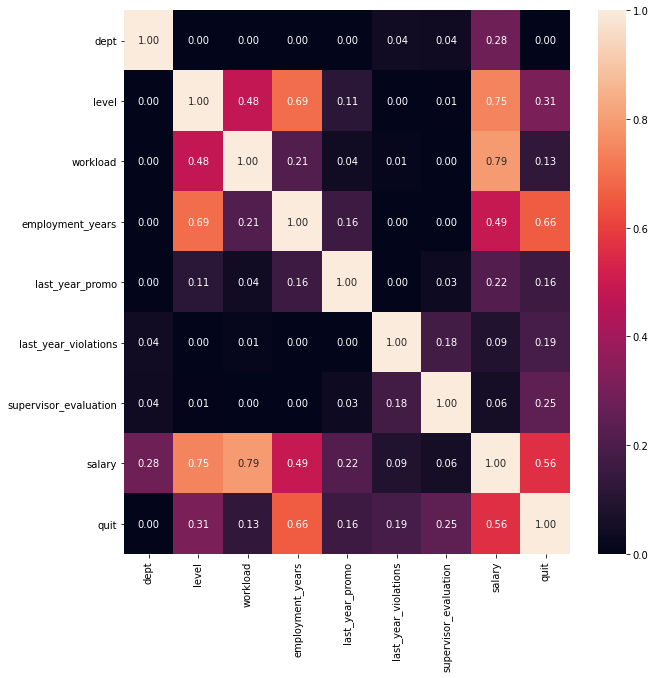

In [67]:
plt.figure(figsize=(10, 10))
phik_corr = train_2.phik_matrix()
sns.heatmap(phik_corr, annot=True, fmt='.2f')
plt.show()

*Вывод:* Мультиколлинеарности нет: везде коэф. корреляции не выше 0.8

### Добавление нового входного признака

In [68]:
X_train_2 = train_2.drop(['quit'], axis=1)
y_train_2 = train_2['quit']

In [69]:
test_2 = X_test_2.merge(y_test_2, left_index=True, right_index=True)
X_test_2 = test_2.drop(['quit'], axis=1)
y_test_2 = test_2['quit']

In [70]:
X_train_2['job_satisfaction_rate'] = best_regressor.predict(X_train_2)
X_test_2['job_satisfaction_rate'] = best_regressor.predict(X_test_2)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [71]:
X_train_2.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,0.554235
814010,sales,junior,medium,2,no,no,4,27600,0.841792
155091,purchasing,middle,medium,5,no,no,1,37200,0.285772
257132,sales,junior,medium,2,no,yes,3,24000,0.279847
910140,marketing,junior,medium,2,no,no,5,25200,0.735972


In [72]:
X_test_2.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.799933
686555,hr,junior,medium,1,no,no,4,30000,0.694961
467458,sales,middle,low,5,no,no,4,19200,0.621597
418655,sales,middle,low,6,no,no,4,19200,0.674435
789145,hr,middle,medium,5,no,no,5,40800,0.716179


*Вывод:*

Доавили столбец job_satisfaction_rate, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи

### Подготовка данных

Воспользуемся готовым паплайном из задачи №1, только добавим в списки признаков новый

In [73]:
ohe_col = ['dept', 'last_year_promo', 'last_year_violations']
ord_col = ['level', 'workload']
num_col = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']

Кодирование целевого признака "quit"

Нас больше интересуют уволившиеся сотрудники, поэтому: если сотрудник уволился, то quit - 1, если нет, то quit - 0

In [74]:
le = LabelEncoder()
le.fit(['no', 'yes'])

y_train_2 = le.transform(y_train_2)
y_test_2 = le.transform(y_test_2)

Так как у нас сейчас задача бинарной классификации, то заменим модель в паплайне

In [75]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('feature_selection', SelectKBest(score_func=f_classif)),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE)),
    ]
)

### Обучение модели

Для отбора признаков воспользуемся SelectKBest

In [76]:
param_distributions = [
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 20),
        'feature_selection__k': [4, 6, 'all'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]   
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 11),
        'models__min_samples_split': range(2, 11),
        'feature_selection__k': [4, 6, 'all'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__C': [0.1, 1, 10, 100],  
        'models__gamma': ['scale', 'auto'], 
        'feature_selection__k': [4, 6, 'all'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', max_iter=1000)],
        'models__C': [0.01, 0.1, 1, 10, 100], 
        'feature_selection__k': [4, 6, 'all'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

In [77]:
grid_class = GridSearchCV(
    pipe_final,
    param_distributions,
    cv=5,
    n_jobs=-1,
    scoring='roc_auc'
)

In [78]:
grid_class.fit(X_train_2, y_train_2)

/opt/conda/lib/python3.9/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['dept',
                                                                          'last_year_promo',
                                                                          'last_year_violations']),
                                                                        ('ord',
                                                                         Pipeline(steps=[('simpleImput...
                          'models__C': [0.1, 1, 10, 100],
                          'models__gamma': ['scale', 'auto'],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'feature_selection__k': [4, 6, 'all'],
                          'models': [LogisticRegression(max_iter=1000,
                                                        random_state=42,
                                                        solver='liblinear')],
                          'models__C': [0.01, 0.1, 1, 10, 100],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring='roc_auc')

In [79]:
best_classifier = grid_class.best_estimator_

In [80]:
y_pred_2 = best_classifier.predict_proba(X_test_2)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [81]:
roc_auc_score(y_test_2, y_pred_2[:, 1])

0.9273636134652996

In [83]:
results = grid_class.cv_results_
results_df = pd.DataFrame(results)

ranking_columns = ['params', 'mean_test_score', 'rank_test_score']
ranking_df = results_df[ranking_columns].sort_values(by='rank_test_score')

print("Рейтинг моделей:")
display(ranking_df.head(10))

Рейтинг моделей:


,params,mean_test_score,rank_test_score
907,"{'feature_selection__k': 'all', 'models': SVC(probability=True, random_state=42), 'models__C': 10, 'models__gamma': 'auto', 'preprocessor__num': MinMaxScaler()}",0.932484,1
61,"{'feature_selection__k': 6, 'models': KNeighborsClassifier(), 'models__n_neighbors': 12, 'preprocessor__num': MinMaxScaler()}",0.932094,2
59,"{'feature_selection__k': 6, 'models': KNeighborsClassifier(), 'models__n_neighbors': 11, 'preprocessor__num': MinMaxScaler()}",0.931922,3
63,"{'feature_selection__k': 6, 'models': KNeighborsClassifier(), 'models__n_neighbors': 13, 'preprocessor__num': MinMaxScaler()}",0.931722,4
69,"{'feature_selection__k': 6, 'models': KNeighborsClassifier(), 'models__n_neighbors': 16, 'preprocessor__num': MinMaxScaler()}",0.931721,5
65,"{'feature_selection__k': 6, 'models': KNeighborsClassifier(), 'models__n_neighbors': 14, 'preprocessor__num': MinMaxScaler()}",0.931665,6
67,"{'feature_selection__k': 6, 'models': KNeighborsClassifier(), 'models__n_neighbors': 15, 'preprocessor__num': MinMaxScaler()}",0.931311,7
71,"{'feature_selection__k': 6, 'models': KNeighborsClassifier(), 'models__n_neighbors': 17, 'preprocessor__num': MinMaxScaler()}",0.931021,8
73,"{'feature_selection__k': 6, 'models': KNeighborsClassifier(), 'models__n_neighbors': 18, 'preprocessor__num': MinMaxScaler()}",0.930939,9
31,"{'feature_selection__k': 4, 'models': KNeighborsClassifier(), 'models__n_neighbors': 16, 'preprocessor__num': MinMaxScaler()}",0.930913,10


Анализ моделей:

Лидирующая модель - SVC(C=10, gamma='auto', probability=True, random_state=42)

На последующих местах - KNeighborsClassifier с различными гиперпараметрами

Критерий успеха: ROC-AUC ≥ 0.91 на тестовой выборке

Наша модель: SVC(C=10, gamma='auto', probability=True, random_state=42), SelectKBest(k='all'), ROC-AUC = 0.927

### Выводы к задаче №2

1. Данные были загружены и проверенв на соотвествие ТЗ
2. Была создана функция для предобработки данных: значения приведены к нижнему регистру, удалены явные дубликаты, проверены потенциальные неявные дубликаты, исправлены некорректные значения
3. Были построены графики для каждого из признаков, проведено сравнение структуры данных в тестовой и тренировочной выборках
4. Создан портрет «уволившегося сотрудника»: Больше всего уволившихся сотрудников в "technology"; Больше всего уволившихся сотрудников с низким уровнем загруженности; Больше всего уволившихся сотрудников с уровнем junior; Больше всего увольняются в первый год работы, после 3-го уже мало увольнений; У уволившихся сотрудников была зарплата меньше, чем у тех, кто остался в компании; Уровень удовлетворенности работой у уволившихся сотрудников ниже, чем у других
5. Была проведена проверка на мультиколлинеарность: не обнаружена
6. Добавлен новых входной признак, основываясь на то, что job_satisfaction_rate и quit связаны
7. Изменен паплайн, для отбора признаков использовали SelectKBest
8. Был проведен поиск гиперпараметров с помощью GridSearchCV для моделей: KNeighborsClassifier, DecisionTreeClassifier, SVС, LogisticRegression
9. Лучшая модель: SVC(C=10, gamma='auto', probability=True, random_state=42), SelectKBest(k='all'), ROC-AUC = 0.927

## Вывод

**Общий вывод**

Задача №1

1. Данные были загружены и проверенв на соотвествие ТЗ
2. Была создана функция для предобработки данных: значения приведены к нижнему регистру, удалены явные дубликаты, проверены потенциальные неявные дубликаты, исправлены некорректные значения
3. Были построены графики для каждого из признаков, проведено сравнение структуры данных в тестовой и тренировочной выборках
4. Была проведена проверка на мультиколлинеарность: не обнаружена
5. Был создан паплайн с кодированием (OneHotEncoder, OrdinalEncoder) и маштабированием (StandardScaler), также заполнены пропуски в паплайне с помощью SimpleImputer
6. Был проведен поиск гиперпараметров с помощью GridSearchCV для моделей: KNeighborsRegressor, DecisionTreeRegressor, SVR, LinearRegression
7. Создана метрика SMAPE
8. Лучшая модель: SVR(C=10) cо значением метрики SMAPE = 13.551

Задача №2

1. Данные были загружены и проверенв на соотвествие ТЗ
2. Была создана функция для предобработки данных: значения приведены к нижнему регистру, удалены явные дубликаты, проверены потенциальные неявные дубликаты, исправлены некорректные значения
3. Были построены графики для каждого из признаков, проведено сравнение структуры данных в тестовой и тренировочной выборках
4. Создан портрет «уволившегося сотрудника»: Больше всего уволившихся сотрудников в "technology"; Больше всего уволившихся сотрудников с низким уровнем загруженности; Больше всего уволившихся сотрудников с уровнем junior; Больше всего увольняются в первый год работы, после 3-го уже мало увольнений; У уволившихся сотрудников была зарплата меньше, чем у тех, кто остался в компании; Уровень удовлетворенности работой у уволившихся сотрудников ниже, чем у других
5. Была проведена проверка на мультиколлинеарность: не обнаружена
6. Добавлен новых входной признак, основываясь на то, что job_satisfaction_rate и quit связаны
7. Изменен паплайн, для отбора признаков использовали SelectKBest
8. Был проведен поиск гиперпараметров с помощью GridSearchCV для моделей: KNeighborsClassifier, DecisionTreeClassifier, SVС, LogisticRegression
9. Лучшая модель: SVC(C=10, gamma='auto', probability=True, random_state=42), SelectKBest(k='all'), ROC-AUC = 0.927